In [1]:
import sys
sys.path.append("..")  # sobe um nível até a raiz

import _setup

2026-02-13 13:19:39,694 | INFO | Project root detected: C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-6
2026-02-13 13:19:39,695 | INFO | SRC detected at: C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-6\src
2026-02-13 13:19:39,699 | INFO | Added to PYTHONPATH: C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-6\src
2026-02-13 13:19:39,701 | INFO | Added to PYTHONPATH: C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-6\src\ingestion
2026-02-13 13:19:39,703 | INFO | Added to PYTHONPATH: C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-6\src\modeling
2026-02-13 13:19:39,705 | INFO | Added to PYTHONPATH: C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-6\src\transformation
2026-02-13 13:19:39,707 | INFO | Added to 

# IMPORTS

In [2]:
# =====================================================
# JUPYTER CONFIGURATION
# =====================================================
# Ativa renderização inline de gráficos (somente Jupyter)
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except NameError:
    # Caso não esteja rodando em Jupyter
    pass


# =====================================================
# STANDARD LIBRARIES (Built-in)
# =====================================================
import datetime as dt
import warnings


# =====================================================
# THIRD-PARTY LIBRARIES
# =====================================================
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError as e:
    raise ImportError(
        "Erro ao importar bibliotecas básicas. "
        "Verifique se numpy, pandas, matplotlib e seaborn estão instalados."
    ) from e


# =====================================================
# PROPHET (Time Series Forecasting)
# =====================================================
try:
    from prophet.diagnostics import cross_validation, performance_metrics
except ImportError as e:
    raise ImportError(
        "Prophet não está instalado. Execute: pip install prophet"
    ) from e


# =====================================================
# OPTIONAL: Plotly (Interactive Plots)
# =====================================================
try:
    import plotly
except ImportError:
    print("Aviso: Plotly não está instalado. Gráficos interativos não funcionarão.")


# =====================================================
# GLOBAL CONFIGURATION
# =====================================================
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")


# LOADING DATA

In [3]:
from ingestion.covid_data_loader import CovidDataLoader

GITHUB_API = (
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
    "csse_covid_19_data/csse_covid_19_time_series/"
    "time_series_covid19_confirmed_global.csv"
)

# Ingestão
loader = CovidDataLoader(GITHUB_API)
df = loader.load()

2026-02-13 13:19:42,390 | INFO | Carregando dados da URL...
2026-02-13 13:19:42,775 | INFO | Dados carregados com sucesso.


# Filtetring data to the only include India

In [4]:
from transformation.covid_transformer import CovidDataTransformer
# Transformação
transformer = CovidDataTransformer(df)
df_india = transformer.filter_by_country("India")

df_india.head()

2026-02-13 13:19:42,815 | INFO | Filtro aplicado para país: India


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
148,NaN,India,20.593684,78.96288,0,0,0,0,0,0,...,44687837,44688105,44688388,44688722,44689046,44689327,44689593,44689919,44690298,44690738


# Converting the above DataFrame to the format accepted by FB Prophet

In [5]:
from transformation.time_series_transformer import TimeSeriesTransformer

transformer = TimeSeriesTransformer(df_india)

df_prophet = transformer.to_prophet_format()

df_prophet.head()

2026-02-13 13:19:42,874 | INFO | Convertendo dataset para formato long (ds, y)...
2026-02-13 13:19:43,003 | INFO | Conversão concluída com sucesso.


,ds,y
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


# Subtracting each row by the preceding row value to get the amount of cases increase by day 

In [6]:
# Converter para casos diários
df_daily = TimeSeriesTransformer.to_daily_cases(df_prophet)

df_daily.tail()

2026-02-13 13:19:43,041 | INFO | Convertendo série acumulada para casos diários...
2026-02-13 13:19:43,048 | INFO | Conversão para casos diários concluída.


,ds,y
1138,2023-03-05,281.0
1139,2023-03-06,266.0
1140,2023-03-07,326.0
1141,2023-03-08,379.0
1142,2023-03-09,440.0


# Seelcting days only till October

In [7]:
df_selected = TimeSeriesTransformer.filter_until_date(
    df_daily,
    "2020-10-31"
)

df_selected.tail()

2026-02-13 13:19:43,087 | INFO | Filtrando dados até 2020-10-31
2026-02-13 13:19:43,095 | INFO | Filtro por data aplicado com sucesso.


,ds,y
279,2020-10-27,43893.0
280,2020-10-28,49881.0
281,2020-10-29,48648.0
282,2020-10-30,48268.0
283,2020-10-31,46963.0


2026-02-13 13:19:43,138 | INFO | Gerando gráfico da série temporal...


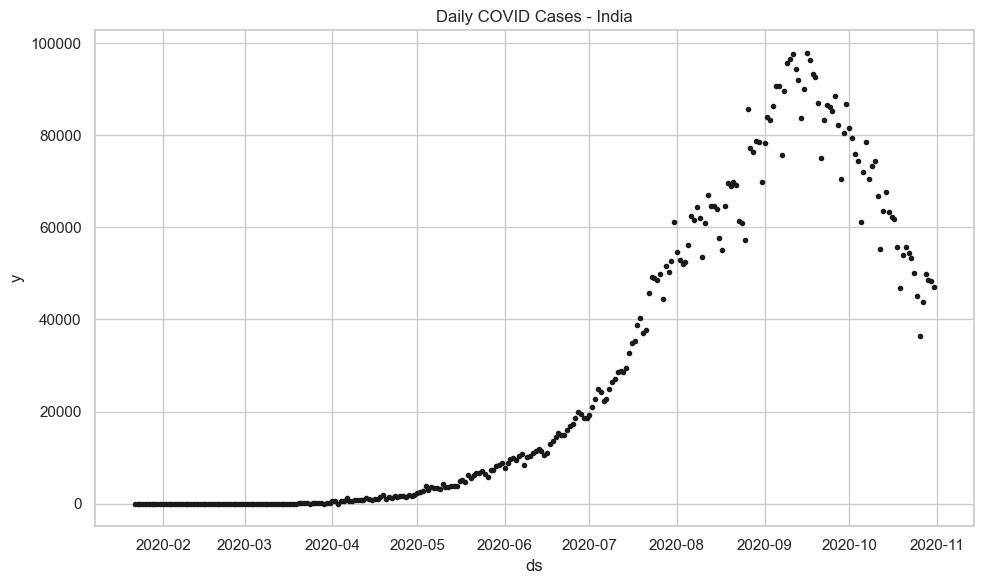

2026-02-13 13:19:43,637 | INFO | Gráfico gerado com sucesso.


In [8]:
from visualization.time_series_visualizer import TimeSeriesVisualizer

TimeSeriesVisualizer.plot_series(
    df_selected,
    title="Daily COVID Cases - India"
)

In [9]:
from modeling.prophet_model import ProphetModel

# Inicializa modelo com feriados da Índia
model = ProphetModel(country_holidays="IN")

# Treina
model.fit(df_selected)

# Gera previsão
forecast = model.predict(periods=60)

forecast.head()

2026-02-13 13:19:44,336 | INFO | Feriados adicionados para o país: IN
2026-02-13 13:19:44,340 | INFO | Modelo Prophet inicializado.
2026-02-13 13:19:44,341 | INFO | Iniciando treinamento do modelo...
2026-02-13 13:19:44,459 | INFO | Chain [1] start processing
2026-02-13 13:19:44,552 | INFO | Chain [1] done processing
2026-02-13 13:19:44,574 | INFO | Treinamento concluído com sucesso.
2026-02-13 13:19:44,576 | INFO | Gerando previsão para 60 dias...
2026-02-13 13:19:44,785 | INFO | Previsão gerada com sucesso.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ashura,Ashura_lower,Ashura_upper,Buddha Purnima,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,571.490556,-2856.882828,3682.386392,571.490556,571.490556,0.0,0.0,0.0,0.0,...,1435.222356,1435.222356,1435.222356,-1667.282087,-1667.282087,-1667.282087,0.0,0.0,0.0,339.430825
1,2020-01-23,770.674243,-2902.236006,3445.559574,770.674243,770.674243,0.0,0.0,0.0,0.0,...,1094.992956,1094.992956,1094.992956,-1481.290980,-1481.290980,-1481.290980,0.0,0.0,0.0,384.376220
2,2020-01-24,969.857930,-2568.361146,3785.649809,969.857930,969.857930,0.0,0.0,0.0,0.0,...,1160.068411,1160.068411,1160.068411,-1393.745692,-1393.745692,-1393.745692,0.0,0.0,0.0,736.180650
3,2020-01-25,1169.041617,-2360.437802,4113.838662,1169.041617,1169.041617,0.0,0.0,0.0,0.0,...,1200.100734,1200.100734,1200.100734,-1390.254943,-1390.254943,-1390.254943,0.0,0.0,0.0,978.887409
4,2020-01-26,1368.225304,-3448.476458,3179.368429,1368.225304,1368.225304,0.0,0.0,0.0,0.0,...,-166.370831,-166.370831,-166.370831,-1456.629731,-1456.629731,-1456.629731,0.0,0.0,0.0,3.325562


In [10]:
from modeling.prophet_model import ProphetModel

model = ProphetModel(country_holidays="IN")

# Split temporal
train_df, test_df = ProphetModel.temporal_split(df_selected, split_index=60)

# Treina
model.fit(train_df)

# Previsão sobre teste
forecast_test = model.predict_on_dataframe(test_df)

forecast_test.head()


2026-02-13 13:19:45,023 | INFO | Feriados adicionados para o país: IN
2026-02-13 13:19:45,026 | INFO | Modelo Prophet inicializado.
2026-02-13 13:19:45,028 | INFO | Iniciando treinamento do modelo...
2026-02-13 13:19:45,104 | INFO | Chain [1] start processing
2026-02-13 13:19:45,685 | INFO | Chain [1] done processing
2026-02-13 13:19:45,704 | INFO | Treinamento concluído com sucesso.
2026-02-13 13:19:45,706 | INFO | Gerando previsão sobre dataset fornecido...
2026-02-13 13:19:45,926 | INFO | Previsão concluída.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ashura,Ashura_lower,Ashura_upper,Buddha Purnima,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-22,322.087949,101.887370,112.306522,322.087949,322.087949,0.0,0.0,0.0,0.0,...,-0.339910,-0.339910,-0.339910,-214.499896,-214.499896,-214.499896,0.0,0.0,0.0,107.248143
1,2020-03-23,324.711525,139.604389,149.286094,324.711525,324.711525,0.0,0.0,0.0,0.0,...,-1.304528,-1.304528,-1.304528,-178.980852,-178.980852,-178.980852,0.0,0.0,0.0,144.426146
2,2020-03-24,327.335102,189.289358,198.889923,327.335102,327.335102,0.0,0.0,0.0,0.0,...,0.773555,0.773555,0.773555,-134.008374,-134.008374,-134.008374,0.0,0.0,0.0,194.100283
3,2020-03-25,329.958679,246.894494,256.525122,329.958678,329.958679,0.0,0.0,0.0,0.0,...,0.389125,0.389125,0.389125,-78.394305,-78.394305,-78.394305,0.0,0.0,0.0,251.953499
4,2020-03-26,332.582255,316.604756,326.606088,332.582255,332.582255,0.0,0.0,0.0,0.0,...,0.042240,0.042240,0.042240,-11.000644,-11.000644,-11.000644,0.0,0.0,0.0,321.623851


#

2026-02-13 13:19:46,163 | INFO | Feriados adicionados para o país: IN
2026-02-13 13:19:46,164 | INFO | Modelo Prophet inicializado.
2026-02-13 13:19:46,165 | INFO | Iniciando treinamento do modelo...
2026-02-13 13:19:46,278 | INFO | Chain [1] start processing
2026-02-13 13:19:46,361 | INFO | Chain [1] done processing
2026-02-13 13:19:46,383 | INFO | Treinamento concluído com sucesso.
2026-02-13 13:19:46,386 | INFO | Criando dataframe futuro para 30 períodos...
2026-02-13 13:19:46,595 | INFO | Forecast futuro gerado com sucesso.
2026-02-13 13:19:46,596 | INFO | Gerando gráfico de forecast...


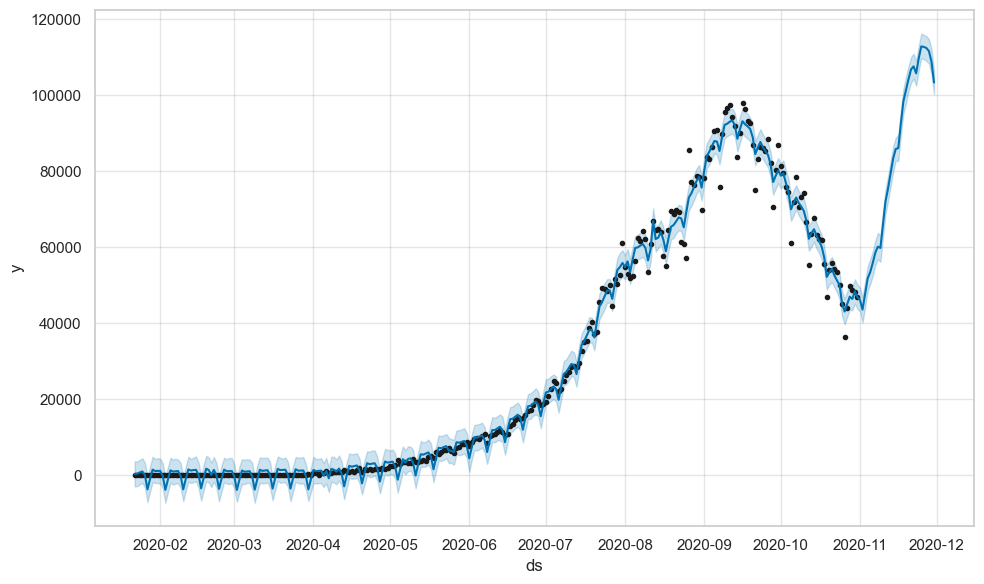

In [11]:
from modeling.prophet_model import ProphetModel
from visualization.prophet_visualizer import ProphetVisualizer

model = ProphetModel(country_holidays="IN")
model.fit(df_selected)

forecast = model.forecast_future(periods=30)

ProphetVisualizer.plot_forecast(model, forecast)


# Interactive Plotting

2026-02-13 13:19:46,976 | INFO | Gerando gráfico interativo de forecast...


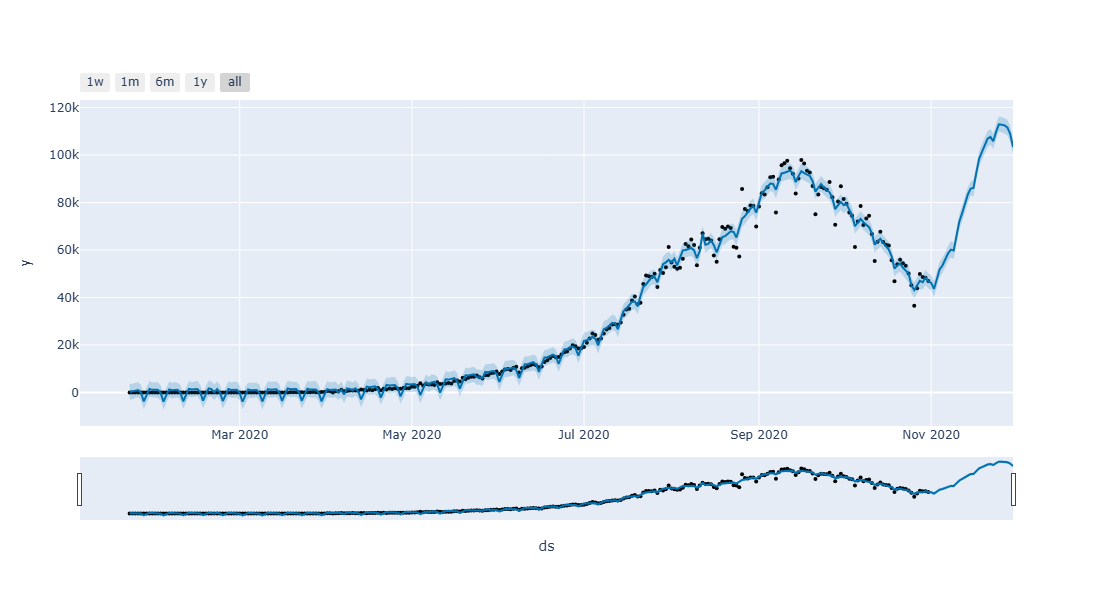

2026-02-13 13:19:50,557 | INFO | Gerando gráfico interativo de componentes...


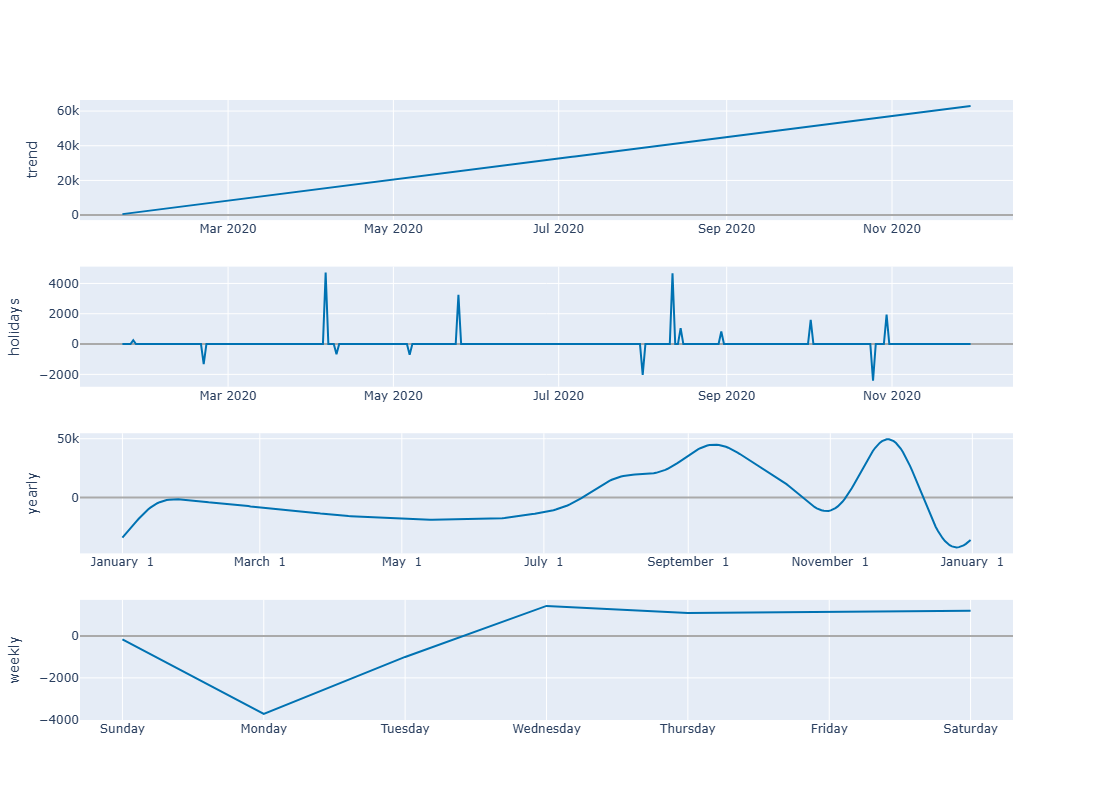

In [12]:
from visualization.prophet_visualizer import ProphetVisualizer

# Forecast já gerado
ProphetVisualizer.plot_forecast_interactive(model, forecast)

# Componentes
ProphetVisualizer.plot_components_interactive(model, forecast)